In [33]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import itertools
import torch.optim as optim
import numpy as np
import csv

In [34]:
def rotation_matrix(n, theta):
    """
    Compute the Rodrigues rotation matrix for a given axis n and angle theta.

    Parameters:
        n (ndarray): rotaion axis (normalized).
        theta (float): rotation angle in radian.

    Returns:
        - (ndarray) -- 3x3 rotation matrix.
    """
    K = np.array([[0.0, -n[2], n[1]], [n[2], 0.0, -n[0]], [-n[1], n[0], 0.0]])
    I = np.eye(3)
    R = I + np.sin(theta) * K + (1.0 - np.cos(theta)) * np.dot(K, K)
    return R


def create_shift_tensor(ks, Rs):
    """
    Create shift tensors for all sites.

    Args:
        ks (list): components of K, (Kxx, Kyy, Kzz, Kyz, Kzx, Kxy).
        Rs (list): symmetry operations for each site.

    Returns:
        - (list) -- shift tensors in each site.
    """
    k1, k2, k3, k4, k5, k6 = ks
    K = [[k1,k6,k5],[k6,k2,k4],[k5,k4,k3]]
    Ks = [R @ K @ R.T for R in Rs]
    return Ks


def nmr_shift(Ks, h):
    """
    Compute the NMR shift without the contributions from the quadrupolar interactions.

    Args:
        Ks (list): list of 3x3 shift tensors.
        h (ndarray): magnetic field.

    Returns:
        - (list) -- NMR shift for each K.
    """
    shift = [np.diag(h @ K @ h.T) for K in Ks]
    return shift


def compute_shift(n, s, ks, Rs):
    """
    Compute angle dependence of NMR shift.

    Args:
        n (list): rotation axis.
        s (list): starting vector.
        ks (list): components of K, (Kxx, Kyy, Kzz, Kyz, Kzx, Kxy).
        Rs (list): symmetry operations for each site.

    Returns:
        - (ndarray) -- angles.
        - (list) -- angle dependence of NMR shift around n axis.
        - (list) -- angle dependence of NMR shift around nxs axis.
    """
    theta = np.radians(range(91))

    n = np.array(n)
    n1 = n / np.linalg.norm(n)
    s = np.array(s)
    s = s / np.linalg.norm(s)
    n2 = np.cross(n1, s)
    n3 = (n1 + n2) / np.sqrt(2)
    h1 = np.array([rotation_matrix(n1, t) @ s for t in theta])
    h2 = np.array([rotation_matrix(n2, t) @ s for t in theta])
    h3 = np.array([rotation_matrix(n3, t) @ s for t in theta])

    Ks = create_shift_tensor(ks, Rs)

    shift1 = nmr_shift(Ks, h1)
    shift2 = nmr_shift(Ks, h2)
    shift3 = nmr_shift(Ks, h3)

    return theta, shift1, shift2, shift3


def plot_data(theta, shift1, shift2, shift3):
    """
    Plot angle dependences.

    Args:
        theta (ndarray): angles.
        shift1 (list): angle dependence of NMR shift around n axis.
        shift2 (list): angle dependence of NMR shift around nxs axis.
    """
    fig, axes = plt.subplots(1, 1, figsize=(5, 5), constrained_layout=True)
    axes.set_title("Knight shift of Te")
    axes.set_xlabel("Rotation angle [deg.]", fontsize=15)
    axes.set_ylabel(r"Knight shift [$\times {10}^4$]", fontsize=15)

    axes.set_xlim([0, 90])
    axes.grid()

    n_site = len(shift1)
    colors = ["blue", "green", "red"]
    theta = theta * 180/np.pi
    for site in range(n_site):
        axes.plot(theta, shift1[site]*10000, "-", color=colors[site], label=f'$K_{site+1}$')
    for site in range(n_site):
        axes.plot(theta, shift2[site]*10000, "--", color=colors[site], label=f'$K_{site+1}$')
    for site in range(n_site):
        axes.plot(theta, shift3[site]*10000, ":", color=colors[site], label=f'$K_{site+1}$')
    axes.legend()

    plt.autoscale(enable=True, axis='y')
    plt.show()

def output_shift_values(theta, shift1, shift2, shift3):
    """
    Output angle and shift values in the specified format.
    """
    for j in range(3):
        print(f"Angle,Shift1[{j+1}] value")  # jの値を表示する
        for i in range(0, 91):
            print(f"{i},{shift1[j][i]*10000}")
    for j in range(3):
        print(f"Angle,Shift2[{j+1}] value")  # jの値を表示する
        for i in range(0, 91):
            print(f"{i},{shift2[j][i]*10000}")
    for j in range(3):
        print(f"Angle,Shift3[{j+1}] value")  # jの値を表示する
        for i in range(0, 91):
            print(f"{i},{shift3[j][i]*10000}")

In [35]:
def generate_vectors():
    # t1, p1 をランダム生成
    t1 = np.random.uniform(0, 180)  # 0° <= t1 <= 180°
    p1 = np.random.uniform(-180, 180)  # -180° <= p1 <= 180°

    # ベクトル n を計算
    nx = np.cos(np.radians(p1)) * np.sin(np.radians(t1))
    ny = np.sin(np.radians(p1)) * np.sin(np.radians(t1))
    nz = np.cos(np.radians(t1))
    n = np.array([nx, ny, nz])

    while True:
        # ランダムなベクトルを生成
        random_vec = np.random.randn(3)
        # 直交条件を満たすように調整
        s = random_vec - np.dot(random_vec, n) * n
        if np.linalg.norm(s) > 1e-6:  # 0ベクトルでない場合にのみ採用
            s = s / np.linalg.norm(s)  # s を正規化
            # t2, p2 を逆算
            t2 = np.degrees(np.arccos(s[2]))
            p2 = np.degrees(np.arctan2(s[1], s[0]))
            if p2 < 0:
                p2 += 360  # p2 を 0°〜360° に変換

            # p2 が 120° 以下であれば終了
            if p2 <= 120:
                break

    return t1, p1, t2, p2, n, s

# ランダム生成と内積の確認
t1, p1, t2, p2, n, s = generate_vectors()
dot_product = np.dot(n, s)

print(f"t1: {t1}, p1: {p1}")
print(f"t2: {t2}, p2: {p2}")
print(f"n: {n}")
print(f"s: {s}")
print(f"内積 (n・s): {dot_product}")

t1: 134.05903821343566, p1: 25.25048441509935
t2: 52.62760609100712, p2: 67.59480240191951
n: [ 0.64996025  0.30654787 -0.69539922]
s: [0.30290601 0.73471589 0.60699301]
内積 (n・s): -1.3444417850504085e-16


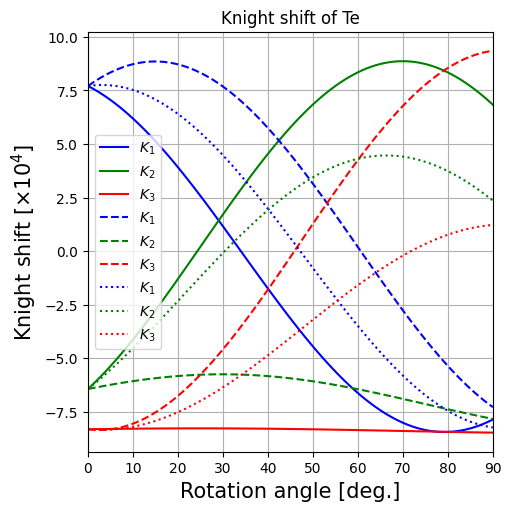

Angle,Shift1[1] value
0,7.707905128905447
1,7.5961219898068695
2,7.474994094236655
3,7.344669017877236
4,7.205305541759118
5,7.057073458810653
6,6.9001533669915105
7,6.734736449261887
8,6.561024240655513
9,6.379228382740257
10,6.189570365765488
11,5.99228125881031
12,5.787601428261492
13,5.575780244964042
14,5.357075780401264
15,5.131754492274384
16,4.900090899864898
17,4.662367249575117
18,4.418873171054402
19,4.1699053243300375
20,3.915767038372708
21,3.6567679415368413
22,3.3932235843261846
23,3.1254550549441005
24,2.853788588097064
25,2.5785551675279184
26,2.3000901227631654
27,2.018732720565599
28,1.7348257515900116
29,1.4487151127455813
30,1.1607493857737863
31,0.871279412555208
32,0.5806578676627877
33,0.28923882868215917
34,-0.0026226551773398366
35,-0.29457099565544276
36,-0.5862504986704713
37,-0.8773057976777844
38,-1.167382286629176
39,-1.4561265520057094
40,-1.743186803397678
41,-2.028213302106997
42,-2.3108587872499546
43,-2.5907788988411067
44,-2.8676325973428645
45,-3.1

In [36]:
# In the case of Te. (Te1 is on y-bond).
ks = [-8.572e-4, 1.146e-4, 0.0, 8.830e-4, 0.0, 0.0]

E = np.eye(3)
C3 = rotation_matrix([0,0,1], 2.0*np.pi/3.0) # for Te2.
C3i = C3.T # for Te3.

Rs = [E, C3i, C3]

theta, shift1, shift2, shift3 = compute_shift(n, s, ks, Rs)
plot_data(theta, shift1, shift2, shift3)

# 指定フォーマットで出力
output_shift_values(theta, shift1, shift2, shift3)

In [37]:

def save_to_csv(filename, angles, shifts, index):
    """
    Save the angles and shifts to a CSV file.

    Args:
        filename (str): Output CSV file name.
        angles (ndarray): Array of angles.
        shifts (list): Shift values for one site.
        index (int): Site index (1-based).
    """
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Header
        writer.writerow(["x", "y"])
        # Data
        for angle, shift in zip(angles, shifts):
            writer.writerow([angle, shift])

def output_shift_to_csv(theta, shift1, shift2, shift3):
    """
    Output angle and shift values to CSV files.

    Args:
        theta (ndarray): Array of angles.
        shift1 (list): Shift values for each site around n axis.
        shift2 (list): Shift values for each site around nxs axis.
    """
    # Convert angles to degrees
    angles = np.round(theta * 180 / np.pi).astype(int)  # 四捨五入で整数化
    
    # Save Shift1 data
    for i, shifts in enumerate(shift1, start=1):
        filename = f"sample({i}).csv"
        save_to_csv(filename, angles, shifts * 10000, i)
    
    # Save Shift2 data
    for i, shifts in enumerate(shift2, start=1):
        filename = f"sample{i}.csv"
        save_to_csv(filename, angles, shifts * 10000, i)
    
    # Save Shift3 data
    for i, shifts in enumerate(shift3, start=1):
        filename = f"sample{i}{i}.csv"
        save_to_csv(filename, angles, shifts * 10000, i)

# 実行例
output_shift_to_csv(theta, shift1, shift2, shift3)

In [38]:
def rotation_matrix(n, theta):
    """
    Compute the Rodrigues rotation matrix for a given axis n and angle theta.

    Parameters:
        n (torch.Tensor): Rotation axis (normalized).
        theta (float): Rotation angle in radian.

    Returns:
        - (torch.Tensor) -- 3x3 rotation matrix.
    """
    K = torch.tensor([[0.0, -n[2], n[1]], 
                      [n[2], 0.0, -n[0]], 
                      [-n[1], n[0], 0.0]])
    I = torch.eye(3)
    R = I + torch.sin(theta) * K + (1.0 - torch.cos(theta)) * torch.mm(K, K)
    return R

def cross_product(v1, v2):
    return torch.cross(v1, v2, dim=0)

def magnetic(axis, vec, theta):
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    
    axis = axis.unsqueeze(0)  # (1, 3)
    vec = vec.unsqueeze(0)    # (1, 3)
    
    rotated_vecs = []
    for i in range(theta.size(0)):
        theta_i = theta[i]
        cos_theta_i = cos_theta[i]
        sin_theta_i = sin_theta[i]
        
        axis_i = axis[0]
        vec_i = vec[0]
        
        rotated_vec = vec_i * cos_theta_i + cross_product(axis_i, vec_i) * sin_theta_i + axis_i * (torch.matmul(axis_i.unsqueeze(1).T, vec_i.unsqueeze(1)).squeeze() * (1 - cos_theta_i))
        rotated_vecs.append(rotated_vec)
    
    return torch.stack(rotated_vecs)

def model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
    rad = torch.pi / 180.0  # Conversion factor from degrees to radians
    nx = torch.cos(p1 * rad) * torch.sin(t1 * rad)
    ny = torch.sin(p1 * rad) * torch.sin(t1 * rad)
    nz = torch.cos(t1 * rad)
    sx = torch.cos(p2 * rad) * torch.sin(t2 * rad)
    sy = torch.sin(p2 * rad) * torch.sin(t2 * rad)
    sz = torch.cos(t2 * rad)
    theta = x * rad

    # Define matrices
    E = torch.eye(3)
    C3 = rotation_matrix(torch.tensor([0.0, 0.0, 1.0]), torch.tensor([2.0 * torch.pi / 3.0])) # for Te2.
    C3i = C3.T # for Te3.
    Rs = [E, C3i, C3]
    
    h = magnetic(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz]), theta)
    ht = magnetic((cross_product(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz]))), torch.stack([sx, sy, sz]), theta)
    k = torch.stack([
    torch.stack([k1, k6, k5]),
    torch.stack([k6, k2, k4]),
    torch.stack([k5, k4, k3])
    ])
    Ks = [torch.einsum('ik,kl,jl->ij', R, k, R) for R in Rs]
    shift1 = [torch.einsum('ij,jk,ik->i', h, K, h) for K in Ks]
    shift2 = [torch.einsum('ij,jk,ik->i', ht, K, ht) for K in Ks]
    return {'shift1': torch.stack(shift1), 'shift2': torch.stack(shift2)}

In [39]:
# 各CSVファイルの読み込み
csv_files1 = ['sample(1).csv', 'sample(2).csv', 'sample(3).csv']
df1 = [pd.read_csv(f) for f in csv_files1]

csv_files2 = ['sample1.csv', 'sample2.csv', 'sample3.csv']
df2 = [pd.read_csv(f) for f in csv_files2]

dfs = [df1, df2]

# データの抽出
x_values = []
y_values = []

for df_group in dfs:
    for i in range(len(df_group)):
        x_values.append(df_group[i]['x'].values)
        y_values.append(df_group[i]['y'].values)

# リストの全てのデータをtorch.tensorに変換
x_tensors = []
y_tensors = []

for x, y in zip(x_values, y_values):
    x_tensors.append(torch.tensor(x, dtype=torch.float32, requires_grad=True))
    y_tensors.append(torch.tensor(y, dtype=torch.float32))

# 結果を個別に代入（必要なら）
x1, x2, x3, x4, x5, x6 = x_tensors
y1, y2, y3, y4, y5, y6 = y_tensors

In [40]:
def loss_fn(y_p, y):
    squared_diffs = (y_p - y)**2
    return squared_diffs.mean()

In [41]:
def combined_loss_fn(*args):
    total_loss = 0
    # y_predとy_actualをペアでループしながらlossを計算
    for y_pred, y_actual in zip(args[::2], args[1::2]):
        total_loss += loss_fn(y_pred, y_actual)
    
    return total_loss

In [42]:
# [0,1,2] の順列を計算
permutations = list(itertools.permutations([0, 1, 2]))

# 6通りの組み合わせを生成
filtered_combinations = [(perm, perm) for perm in permutations]

# 最適化のためのobjective関数
def objective(trial, perm):
    k1 = torch.tensor(trial.suggest_float('k1', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k2 = torch.tensor(trial.suggest_float('k2', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k3 = torch.tensor(trial.suggest_float('k3', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k4 = torch.tensor(trial.suggest_float('k4', 0.0, 10.0), dtype=torch.float32, requires_grad=True)
    k5 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
    k6 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
    t1 = torch.tensor(trial.suggest_float('t1', 0.0, 180.0), dtype=torch.float32, requires_grad=True)
    p1 = torch.tensor(trial.suggest_float('p1', -180.0, 180.0), dtype=torch.float32, requires_grad=True)
    t2 = torch.tensor(trial.suggest_float('t2', 0.0, 180.0), dtype=torch.float32, requires_grad=True)
    p2 = torch.tensor(trial.suggest_float('p2', 0.0, 120.0), dtype=torch.float32, requires_grad=True)

    # モデルにこれらのパラメータを使用
    outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]
    
    y_p1, y_p2, y_p3 = [outputs[i]['shift1'][perm[i]] for i in range(3)]
    y_p4, y_p5, y_p6 = [outputs[i+3]['shift2'][perm[i]] for i in range(3)]

    loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6)

    return loss.item()

# 全体で最小のLossを保持する変数
global_best_loss = float('inf')
global_best_params = None
global_best_combination = None

# 36通りの組み合わせごとにエポック計算を行うためのループ
for perm in permutations:
    print(f"Evaluating combination: perm1={perm}, perm2={perm}")

    # 最適化のための変数初期化
    best_epoch0_loss = float('inf')
    best_params = None

    for _ in range(5):
        # Optunaで最適化
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, perm), n_trials=100)

        # epoch0のLossが最小のパラメータを保持
        if study.best_value < best_epoch0_loss:
            best_epoch0_loss = study.best_value
            best_params = study.best_params

    # エポック計算 (各組み合わせごとに計算)
    if best_params is not None:
        print(f"Starting training for combination: perm1={perm}, perm2={perm}")
        
        k1 = torch.nn.Parameter(torch.tensor(best_params['k1']))
        k2 = torch.nn.Parameter(torch.tensor(best_params['k2']))
        k3 = torch.nn.Parameter(torch.tensor(best_params['k3']))
        k4 = torch.nn.Parameter(torch.tensor(best_params['k4']))
        k5 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
        k6 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
        t1 = torch.nn.Parameter(torch.tensor(best_params['t1']))
        p1 = torch.nn.Parameter(torch.tensor(best_params['p1']))
        t2 = torch.nn.Parameter(torch.tensor(best_params['t2']))
        p2 = torch.nn.Parameter(torch.tensor(best_params['p2']))

        optimizer = optim.Adam([k1, k2, k3, k4, t1, p1, t2, p2], lr=1e-1)
        prev_loss = float('inf')

        # エポックごとのトレーニング
        best_params_during_epoch = None  # エポックごとの最良パラメータ
        best_epoch_loss = float('inf')  # 最良のロスを記録

        # エポックごとのトレーニング
        for epoch in range(300000):
            optimizer.zero_grad()

            outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]

            y_p1, y_p2, y_p3 = [outputs[i]['shift1'][perm[i]] for i in range(3)]
            y_p4, y_p5, y_p6 = [outputs[i+3]['shift2'][perm[i]] for i in range(3)]

            loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6)

            if epoch == 0:
                epoch0_loss = loss.item()
                if epoch0_loss >= 35:
                    print(f"Epoch 0 Loss is {epoch0_loss}, which is >= 35. Stopping training.")
                    break
            
            # 最良のロスを持つ場合はパラメータを保存
            if loss.item() < best_epoch_loss:
                best_epoch_loss = loss.item()
                best_params_during_epoch = {
                    'k1': k1.item(),
                    'k2': k2.item(),
                    'k3': k3.item(),
                    'k4': k4.item(),
                    'k5': k5.item(),
                    'k6': k6.item(),
                    't1': t1.item(),
                    'p1': p1.item(),
                    't2': t2.item(),
                    'p2': p2.item()
                }

            if loss.item() > prev_loss:
                print(f"Loss increased at epoch {epoch}. Stopping training.")
                break

            prev_loss = loss.item()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                for param in [k1, k2, k3, k4]:
                    param.data = torch.clamp(param.data, -10.0, 10.0)
                for param in [k4]:
                    param.data = torch.clamp(param.data, 0.0, 10.0)
                for param in [t1, t2]:
                    param.data = torch.clamp(param.data, 0.0, 180.0)
                for param in [p1]:
                    param.data = torch.clamp(param.data, -180.0, 180.0)
                for param in [p2]:
                    param.data = torch.clamp(param.data, 0.0, 120.0)

            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')
                # パラメータを表示する
                print(f'Parameters: k1={k1.item()}, k2={k2.item()}, k3={k3.item()}, k4={k4.item()}, k5={k5.item()}, k6={k6.item()}, t1={t1.item()}, p1={p1.item()}, t2={t2.item()}, p2={p2.item()}')

        # 最良のパラメータを表示
        if best_params_during_epoch is not None:
            print(f"Best params during epoch training: {best_params_during_epoch}")
            # 最良のパラメータをTensorに変換して使用
            k1, k2, k3, k4, k5, k6, t1, p1, t2, p2 = [torch.tensor(best_params_during_epoch[param], dtype=torch.float32) for param in ['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 't1', 'p1', 't2', 'p2']]
        else:
            print("No improvement in loss during epoch training.")

        # 現在の組み合わせの最小Lossをグローバルな最小Lossと比較
        if prev_loss < global_best_loss:
            global_best_loss = prev_loss
            global_best_params = best_params_during_epoch
            global_best_combination = (perm, perm)

        print(f"Finished training for combination: perm1={perm}, perm2={perm}")

# 全体で最も良い組み合わせとパラメータを出力
print(f"Global best Loss: {global_best_loss}")
print(f"Global best params: {global_best_params}")
print(f"Global best combination: {global_best_combination}")

[I 2024-11-25 15:27:11,263] A new study created in memory with name: no-name-1cdb1a13-4a92-4a6b-95db-019fc805747b


Evaluating combination: perm1=(0, 1, 2), perm2=(0, 1, 2)


[I 2024-11-25 15:27:11,362] Trial 0 finished with value: 732.060791015625 and parameters: {'k1': 1.1527533459919077, 'k2': 0.20760660896843142, 'k3': 9.808049850456719, 'k4': 1.292117037001096, 't1': 30.87400666472024, 'p1': -100.18575053190028, 't2': 173.69319023023542, 'p2': 59.58957220592544}. Best is trial 0 with value: 732.060791015625.
[I 2024-11-25 15:27:11,412] Trial 1 finished with value: 245.31825256347656 and parameters: {'k1': -7.652980136773017, 'k2': -3.7228918472154904, 'k3': -3.8065150772176137, 'k4': 1.0992214015637458, 't1': 17.048301593463197, 'p1': 30.766240423938882, 't2': 172.6151604234225, 'p2': 43.1943550137433}. Best is trial 1 with value: 245.31825256347656.
[I 2024-11-25 15:27:11,576] Trial 2 finished with value: 604.208251953125 and parameters: {'k1': 8.052047828479981, 'k2': 5.940082710235977, 'k3': -2.12913020834657, 'k4': 3.9715175773683944, 't1': 92.42980531432259, 'p1': -91.2468744064333, 't2': 97.86242851421648, 'p2': 82.2652465470329}. Best is trial 1

Starting training for combination: perm1=(0, 1, 2), perm2=(0, 1, 2)
Epoch 0, Loss: 11.540850639343262
Parameters: k1=-6.2508320808410645, k2=8.553070068359375, k3=-3.4862239360809326, k4=8.208460807800293, k5=0.0, k6=0.0, t1=134.0023193359375, p1=7.414857864379883, t2=46.52796173095703, p2=65.53443908691406
Epoch 100, Loss: 0.583575963973999
Parameters: k1=-10.0, k2=1.2680983543395996, k3=0.09937167167663574, k4=8.788980484008789, k5=0.0, k6=0.0, t1=142.23651123046875, p1=9.442281723022461, t2=51.01255798339844, p2=66.0787124633789
Epoch 200, Loss: 0.23560963571071625
Parameters: k1=-9.500779151916504, k2=0.7884063124656677, k3=0.20550166070461273, k4=8.781822204589844, k5=0.0, k6=0.0, t1=141.37261962890625, p1=14.40946102142334, t2=51.71108627319336, p2=66.89056396484375
Epoch 300, Loss: 0.10377088934183121
Parameters: k1=-9.103100776672363, k2=0.8223121166229248, k3=0.1550086885690689, k4=8.765281677246094, k5=0.0, k6=0.0, t1=139.31118774414062, p1=18.014429092407227, t2=52.143566131

[I 2024-11-25 15:29:52,895] A new study created in memory with name: no-name-d8651ee6-69f0-4708-a705-b3db060a3e59
[I 2024-11-25 15:29:52,947] Trial 0 finished with value: 476.01055908203125 and parameters: {'k1': 7.6172360010040165, 'k2': -2.82643575626871, 'k3': -4.377530623890578, 'k4': 0.9405355957052208, 't1': 73.86396752711315, 'p1': 9.642769281065142, 't2': 94.68103882239755, 'p2': 81.58492358234486}. Best is trial 0 with value: 476.01055908203125.
[I 2024-11-25 15:29:52,998] Trial 1 finished with value: 139.74334716796875 and parameters: {'k1': 9.525612594341347, 'k2': -9.54671068716947, 'k3': -9.12448333338949, 'k4': 7.207373031277027, 't1': 73.74286110385583, 'p1': -148.8201761321961, 't2': 40.90454536579227, 'p2': 119.98239887448916}. Best is trial 1 with value: 139.74334716796875.
[I 2024-11-25 15:29:53,047] Trial 2 finished with value: 303.17388916015625 and parameters: {'k1': -9.533932748801677, 'k2': 8.08352034280746, 'k3': -4.999601374879203, 'k4': 9.736542626835494, 't1

Loss increased at epoch 1434. Stopping training.
Best params during epoch training: {'k1': -8.572017669677734, 'k2': 1.1459614038467407, 'k3': 1.0381462743680459e-05, 'k4': 8.82999324798584, 'k5': 0.0, 'k6': 0.0, 't1': 134.05970764160156, 'p1': 25.249906539916992, 't2': 52.62760543823242, 'p2': 67.59478759765625}
Finished training for combination: perm1=(0, 1, 2), perm2=(0, 1, 2)
Evaluating combination: perm1=(0, 2, 1), perm2=(0, 2, 1)


[I 2024-11-25 15:29:53,205] Trial 4 finished with value: 384.4390869140625 and parameters: {'k1': 9.488945768857995, 'k2': -6.735544421117261, 'k3': 9.480786531547135, 'k4': 6.218390086212814, 't1': 33.66624610146464, 'p1': 103.37852522687393, 't2': 56.220587437742296, 'p2': 98.74906744488635}. Best is trial 1 with value: 139.74334716796875.
[I 2024-11-25 15:29:53,254] Trial 5 finished with value: 405.2252197265625 and parameters: {'k1': 7.948548233170772, 'k2': -8.084961593817365, 'k3': 4.928792428624435, 'k4': 4.854228415909737, 't1': 60.89545495226242, 'p1': -57.9672615662988, 't2': 31.977658153159407, 'p2': 63.404506917670396}. Best is trial 1 with value: 139.74334716796875.
[I 2024-11-25 15:29:53,302] Trial 6 finished with value: 339.2863464355469 and parameters: {'k1': 7.730935582486499, 'k2': 1.2420808729966843, 'k3': -3.399714337953279, 'k4': 4.300561889135398, 't1': 146.47277466919306, 'p1': 84.93700173466408, 't2': 48.335898413092565, 'p2': 12.000412890829137}. Best is trial 

Starting training for combination: perm1=(0, 2, 1), perm2=(0, 2, 1)
Epoch 0, Loss: 21.993377685546875
Parameters: k1=-8.559794425964355, k2=4.679739952087402, k3=0.4403054416179657, k4=9.004016876220703, k5=0.0, k6=0.0, t1=144.9164276123047, p1=171.6521759033203, t2=69.6357421875, p2=95.07049560546875
Epoch 100, Loss: 2.944688320159912
Parameters: k1=-8.43608570098877, k2=3.92612624168396, k3=-0.10086333751678467, k4=8.202071189880371, k5=0.0, k6=0.0, t1=138.0489501953125, p1=167.03598022460938, t2=72.13011169433594, p2=86.87065124511719
Epoch 200, Loss: 1.9414621591567993
Parameters: k1=-8.492372512817383, k2=3.969968795776367, k3=-0.042878732085227966, k4=8.335589408874512, k5=0.0, k6=0.0, t1=137.81312561035156, p1=167.08920288085938, t2=72.04314422607422, p2=83.9051742553711
Epoch 300, Loss: 1.9014337062835693
Parameters: k1=-8.51221752166748, k2=3.9893994331359863, k3=-0.02901725098490715, k4=8.409443855285645, k5=0.0, k6=0.0, t1=138.38182067871094, p1=168.10089111328125, t2=72.123

[I 2024-11-25 15:32:21,086] A new study created in memory with name: no-name-42adbae4-9758-4b67-9512-37922e8c1751
[I 2024-11-25 15:32:21,133] Trial 0 finished with value: 412.14251708984375 and parameters: {'k1': -8.578233262518168, 'k2': -3.805202029798666, 'k3': 1.3465640977921645, 'k4': 6.6081488036668485, 't1': 44.267589424299565, 'p1': -21.06075997634011, 't2': 53.3785322613815, 'p2': 64.4886585290475}. Best is trial 0 with value: 412.14251708984375.
[I 2024-11-25 15:32:21,178] Trial 1 finished with value: 366.7112731933594 and parameters: {'k1': 6.440457968595801, 'k2': -1.7300238590215216, 'k3': -1.1817816866525206, 'k4': 0.5580345239048401, 't1': 9.720082467588206, 'p1': 38.816821207396174, 't2': 106.87658558862482, 'p2': 24.545473879493052}. Best is trial 1 with value: 366.7112731933594.
[I 2024-11-25 15:32:21,224] Trial 2 finished with value: 233.77806091308594 and parameters: {'k1': -2.9522523629444253, 'k2': -2.3276737431584333, 'k3': -8.152908777278862, 'k4': 2.01762625930

Loss increased at epoch 1360. Stopping training.
Best params during epoch training: {'k1': -8.483678817749023, 'k2': 3.9550774097442627, 'k3': 0.08005376160144806, 'k4': 8.624755859375, 'k5': 0.0, 'k6': 0.0, 't1': 137.62701416015625, 'p1': 174.16348266601562, 't2': 72.39859008789062, 'p2': 83.009521484375}
Finished training for combination: perm1=(0, 2, 1), perm2=(0, 2, 1)
Evaluating combination: perm1=(1, 0, 2), perm2=(1, 0, 2)


[I 2024-11-25 15:32:21,316] Trial 4 finished with value: 207.22869873046875 and parameters: {'k1': 1.237509089960092, 'k2': -1.1954262978166241, 'k3': 4.894976617587059, 'k4': 4.092462573669954, 't1': 81.19374656762776, 'p1': -56.927889952343335, 't2': 102.10767235025901, 'p2': 57.45827633586568}. Best is trial 4 with value: 207.22869873046875.
[I 2024-11-25 15:32:21,362] Trial 5 finished with value: 225.69000244140625 and parameters: {'k1': 2.2651035028153075, 'k2': -3.0379825736054356, 'k3': -4.279293787898557, 'k4': 7.460674418530424, 't1': 128.43262243219613, 'p1': 46.173515521594055, 't2': 28.451913439537346, 'p2': 3.983281765520177}. Best is trial 4 with value: 207.22869873046875.
[I 2024-11-25 15:32:21,467] Trial 6 finished with value: 298.3362121582031 and parameters: {'k1': -3.0666467309025798, 'k2': -0.4216023151667674, 'k3': 2.1025565030214075, 'k4': 0.16507398114721572, 't1': 165.74944804805622, 'p1': -92.9440041171371, 't2': 131.31331119944088, 'p2': 59.11017964779099}. Be

Starting training for combination: perm1=(1, 0, 2), perm2=(1, 0, 2)
Epoch 0 Loss is 44.67261505126953, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 0, 2), perm2=(1, 0, 2)
Evaluating combination: perm1=(1, 2, 0), perm2=(1, 2, 0)


[I 2024-11-25 15:32:51,888] Trial 3 finished with value: 360.2676086425781 and parameters: {'k1': -2.0837417099078444, 'k2': 6.667280108349683, 'k3': 4.476582747769637, 'k4': 9.392824341802285, 't1': 63.43496284890759, 'p1': 102.24472798076408, 't2': 18.053169760872564, 'p2': 2.439560749987182}. Best is trial 3 with value: 360.2676086425781.
[I 2024-11-25 15:32:51,963] Trial 4 finished with value: 514.4511108398438 and parameters: {'k1': 8.29971861692886, 'k2': -5.504206288404358, 'k3': 7.6089152954860495, 'k4': 0.28844026460842387, 't1': 145.95945586665087, 'p1': 107.32466681434101, 't2': 93.87835532409366, 'p2': 6.334616449343753}. Best is trial 3 with value: 360.2676086425781.
[I 2024-11-25 15:32:52,007] Trial 5 finished with value: 341.26983642578125 and parameters: {'k1': -8.29056900321139, 'k2': -9.215633499612325, 'k3': 4.849399271055226, 'k4': 8.336988603557614, 't1': 153.786796674744, 'p1': 150.4754164650518, 't2': 121.11800101067233, 'p2': 56.534970652009456}. Best is trial 5

Starting training for combination: perm1=(1, 2, 0), perm2=(1, 2, 0)
Epoch 0 Loss is 52.481258392333984, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 2, 0), perm2=(1, 2, 0)
Evaluating combination: perm1=(2, 0, 1), perm2=(2, 0, 1)


[I 2024-11-25 15:33:22,741] Trial 3 finished with value: 518.6467895507812 and parameters: {'k1': 8.722737045476844, 'k2': 7.512652076681956, 'k3': -7.7147914012534695, 'k4': 6.641576862840603, 't1': 38.66306503598361, 'p1': -10.80888573745014, 't2': 22.699765941739876, 'p2': 26.7571258271952}. Best is trial 2 with value: 172.66099548339844.
[I 2024-11-25 15:33:22,787] Trial 4 finished with value: 684.83154296875 and parameters: {'k1': -2.944638895958061, 'k2': -8.981799728689108, 'k3': 6.246925597386866, 'k4': 8.694500717196986, 't1': 81.12151572489849, 'p1': -18.148269854368152, 't2': 7.0776883346364095, 'p2': 111.49973997686516}. Best is trial 2 with value: 172.66099548339844.
[I 2024-11-25 15:33:22,832] Trial 5 finished with value: 389.84759521484375 and parameters: {'k1': -0.6681714944579973, 'k2': -2.8016592420689594, 'k3': -1.3207488497760007, 'k4': 3.847800406305697, 't1': 76.95755086464696, 'p1': 173.74759051669218, 't2': 31.883598398476728, 'p2': 37.56717825929164}. Best is t

Starting training for combination: perm1=(2, 0, 1), perm2=(2, 0, 1)
Epoch 0, Loss: 25.625564575195312
Parameters: k1=-8.143258094787598, k2=6.672905921936035, k3=-1.3243612051010132, k4=5.9642744064331055, k5=0.0, k6=0.0, t1=53.09945297241211, p1=-15.186941146850586, t2=102.81539154052734, p2=38.866207122802734
Epoch 100, Loss: 2.6847519874572754
Parameters: k1=-8.371697425842285, k2=4.1757917404174805, k3=-0.7526592016220093, k4=8.210604667663574, k5=0.0, k6=0.0, t1=50.70623016357422, p1=-18.471113204956055, t2=108.27733612060547, p2=37.24576187133789
Epoch 200, Loss: 2.351634979248047
Parameters: k1=-8.492280006408691, k2=4.0838189125061035, k3=-0.5060270428657532, k4=8.07699203491211, k5=0.0, k6=0.0, t1=46.317108154296875, p1=-19.725759506225586, t2=109.01631164550781, p2=37.629676818847656
Epoch 300, Loss: 2.0454118251800537
Parameters: k1=-8.58320140838623, k2=4.096291542053223, k3=-0.351824551820755, k4=8.100757598876953, k5=0.0, k6=0.0, t1=42.01104736328125, p1=-26.2789001464843

[I 2024-11-25 15:36:25,721] A new study created in memory with name: no-name-c987ce0e-c0b6-42f0-b80e-59a673a02d58
[I 2024-11-25 15:36:25,771] Trial 0 finished with value: 272.33697509765625 and parameters: {'k1': 4.824035433241892, 'k2': -8.158370186003658, 'k3': -2.764297001533458, 'k4': 6.927188131208105, 't1': 133.85541424179013, 'p1': -107.43433175302356, 't2': 128.03677700803598, 'p2': 103.49966465958055}. Best is trial 0 with value: 272.33697509765625.
[I 2024-11-25 15:36:25,820] Trial 1 finished with value: 592.03662109375 and parameters: {'k1': 8.178033057582752, 'k2': 6.62581889962658, 'k3': 9.55272809088132, 'k4': 7.593333646795461, 't1': 117.1191208477812, 'p1': 11.753418385631676, 't2': 116.70755197878326, 'p2': 49.05927662365286}. Best is trial 0 with value: 272.33697509765625.
[I 2024-11-25 15:36:25,868] Trial 2 finished with value: 810.5489501953125 and parameters: {'k1': -5.3680932830653045, 'k2': 3.126488858891854, 'k3': 9.703347441269901, 'k4': 6.11068300201134, 't1':

Loss increased at epoch 1779. Stopping training.
Best params during epoch training: {'k1': -8.482514381408691, 'k2': 3.9537038803100586, 'k3': 0.0841439962387085, 'k4': 8.633296012878418, 'k5': 0.0, 'k6': 0.0, 't1': 42.41118240356445, 'p1': -54.37176513671875, 't2': 107.59272766113281, 'p2': 37.004150390625}
Finished training for combination: perm1=(2, 0, 1), perm2=(2, 0, 1)
Evaluating combination: perm1=(2, 1, 0), perm2=(2, 1, 0)


[I 2024-11-25 15:36:25,963] Trial 4 finished with value: 238.91085815429688 and parameters: {'k1': -9.994174860406758, 'k2': 8.786538337007038, 'k3': -1.4770765983041034, 'k4': 6.420907781072018, 't1': 22.447326321166162, 'p1': 68.67711089937455, 't2': 101.86976986643046, 'p2': 46.20509520879507}. Best is trial 4 with value: 238.91085815429688.
[I 2024-11-25 15:36:26,011] Trial 5 finished with value: 518.7128295898438 and parameters: {'k1': 1.6486473203741205, 'k2': 2.8650751076070122, 'k3': 8.004785945721114, 'k4': 7.040692371517528, 't1': 70.57910428173294, 'p1': -19.834243116066716, 't2': 144.52663056303294, 'p2': 66.1452820686964}. Best is trial 4 with value: 238.91085815429688.
[I 2024-11-25 15:36:26,123] Trial 6 finished with value: 517.489990234375 and parameters: {'k1': -1.8837557934841236, 'k2': -8.115241262847437, 'k3': 8.888712927560427, 'k4': 5.899173450936001, 't1': 131.8355348373565, 'p1': -50.385744696153836, 't2': 161.30576549432803, 'p2': 17.08991643740984}. Best is tr

Starting training for combination: perm1=(2, 1, 0), perm2=(2, 1, 0)
Epoch 0, Loss: 12.462427139282227
Parameters: k1=-5.75748872756958, k2=4.239983558654785, k3=-4.224293231964111, k4=9.235506057739258, k5=0.0, k6=0.0, t1=121.14350891113281, p1=-105.63807678222656, t2=123.87196350097656, p2=9.773646354675293
Epoch 100, Loss: 1.3630220890045166
Parameters: k1=-7.678501129150391, k2=5.355197906494141, k3=-5.223058700561523, k4=7.598528861999512, k5=0.0, k6=0.0, t1=118.1081771850586, p1=-103.13197326660156, t2=118.80558013916016, p2=10.939556121826172
Epoch 200, Loss: 1.2774362564086914
Parameters: k1=-7.604970455169678, k2=5.242259502410889, k3=-4.996513366699219, k4=7.7826666831970215, k5=0.0, k6=0.0, t1=115.4007797241211, p1=-103.91806030273438, t2=118.28668212890625, p2=10.693182945251465
Epoch 300, Loss: 1.2213332653045654
Parameters: k1=-7.64338493347168, k2=5.2330498695373535, k3=-4.835540294647217, k4=7.937710762023926, k5=0.0, k6=0.0, t1=113.43219757080078, p1=-106.51095581054688

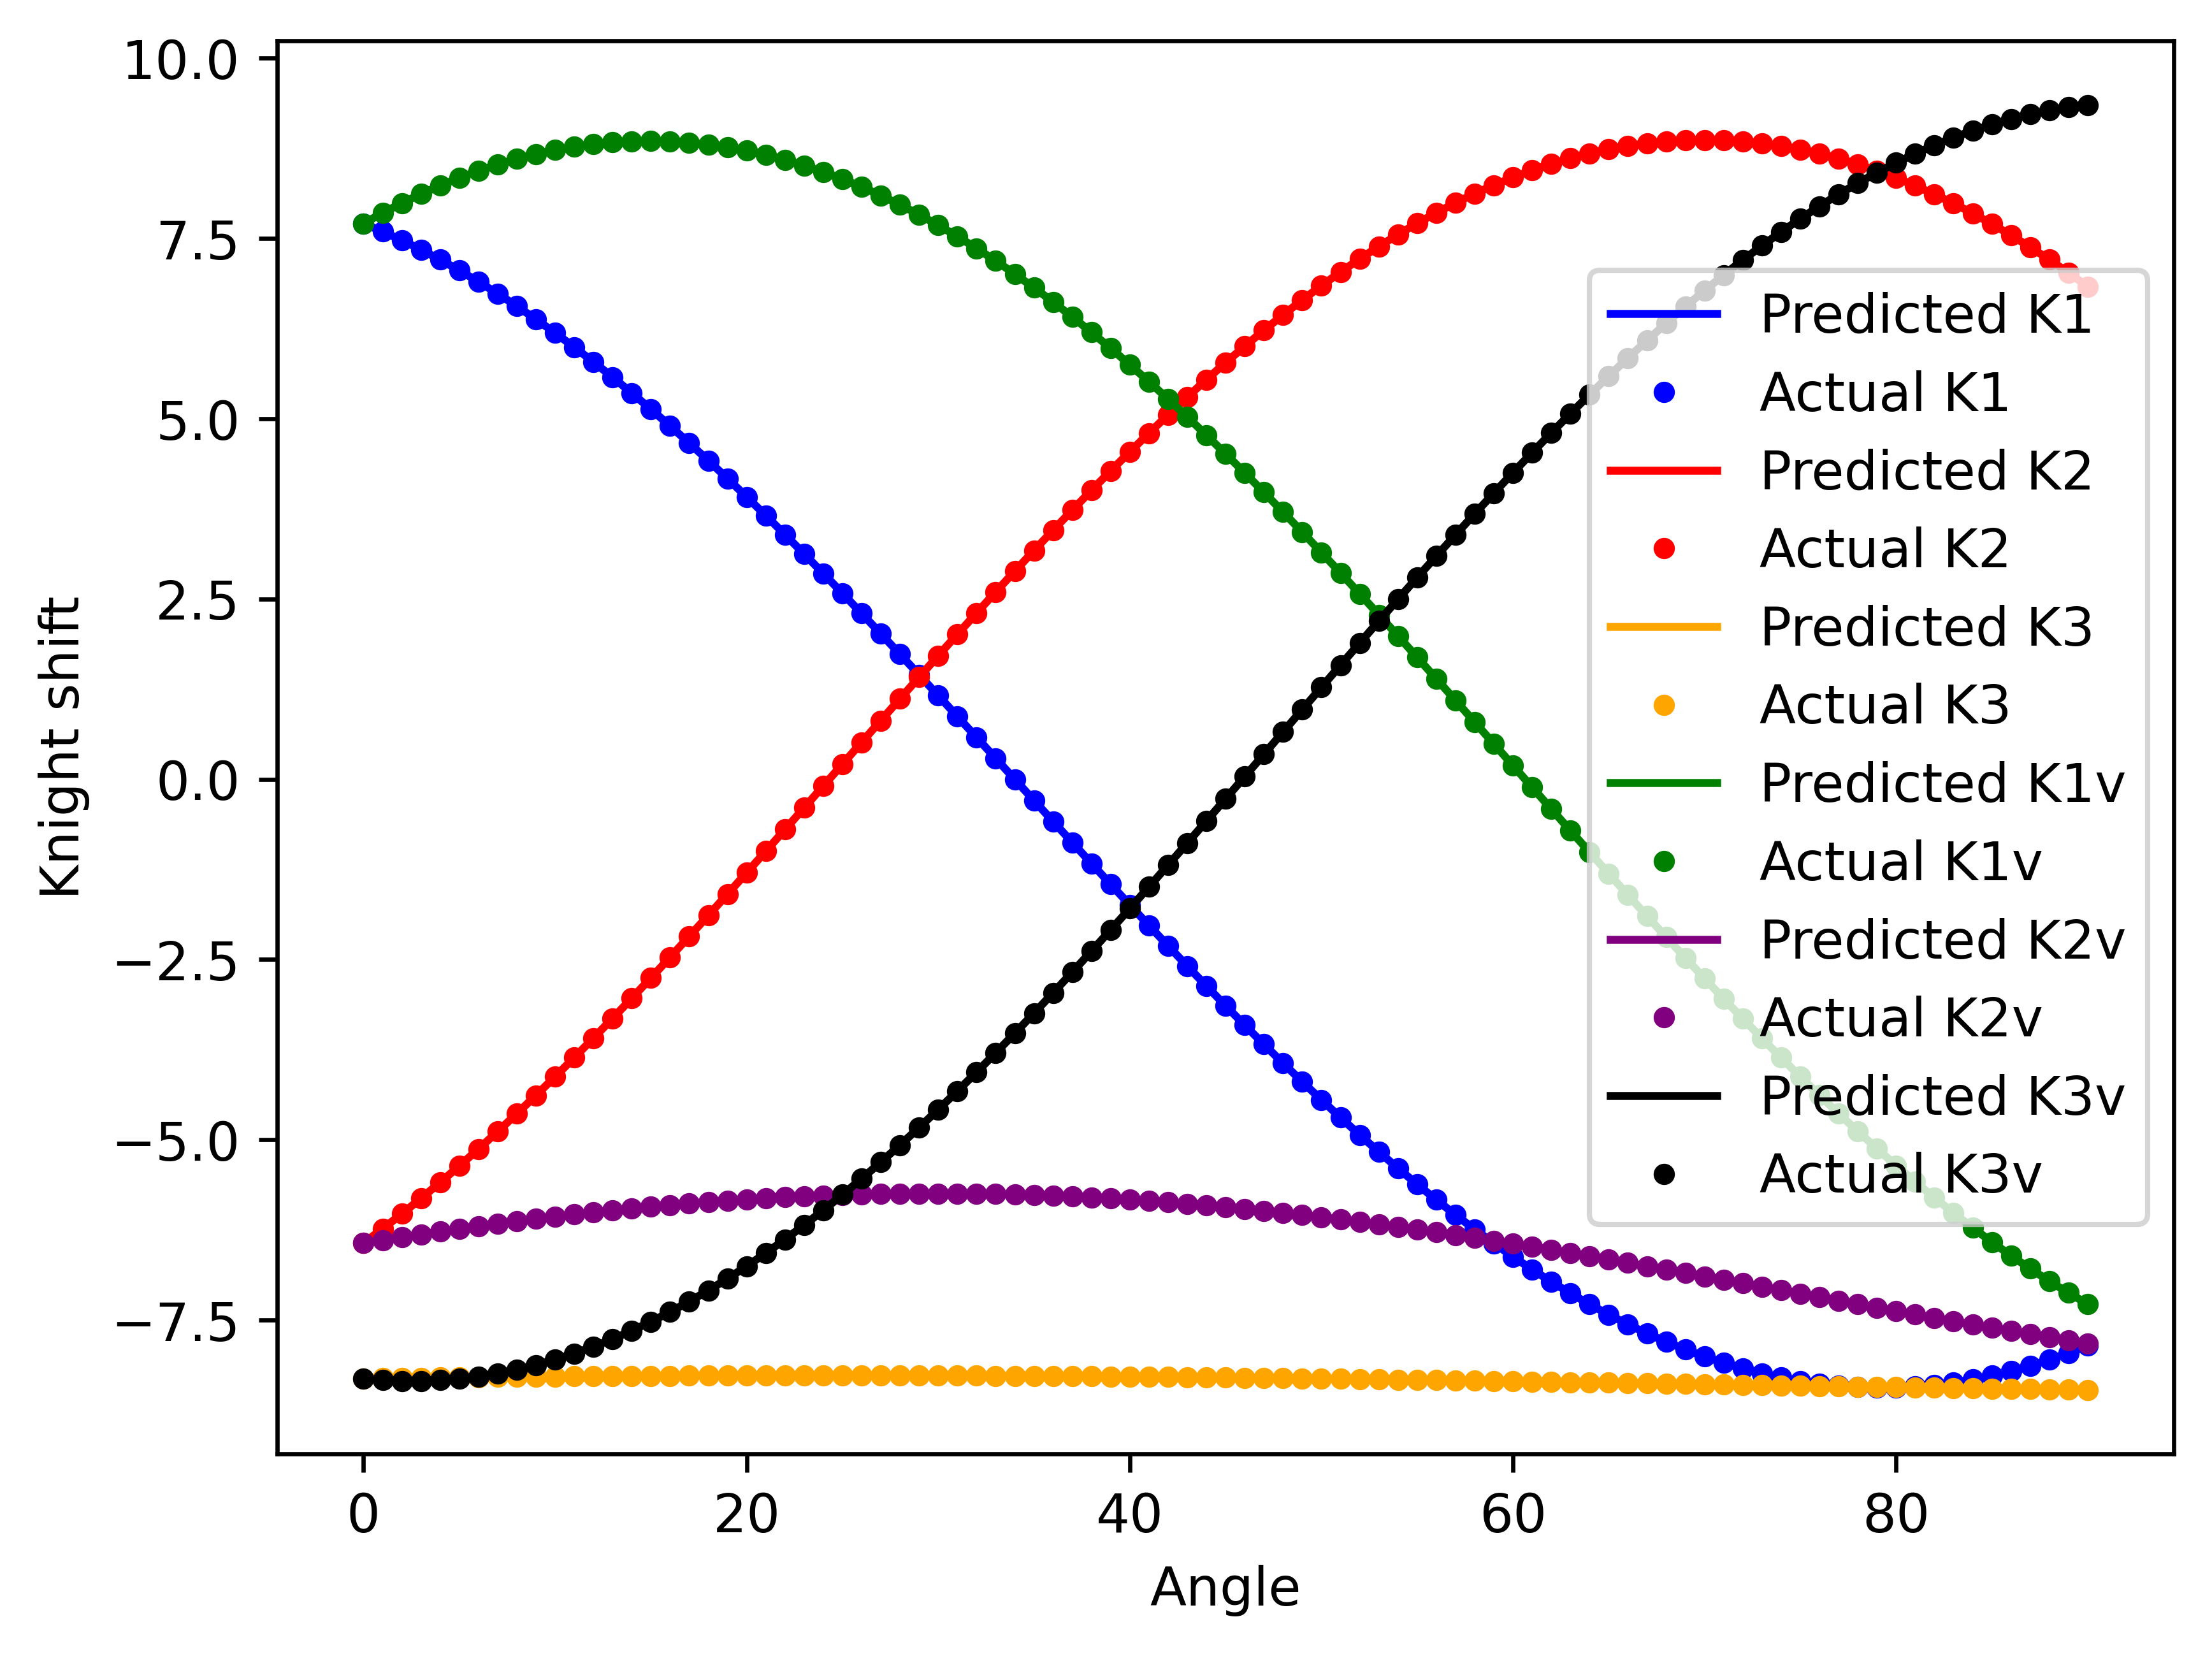

{'k1': -8.572017669677734, 'k2': 1.1459614038467407, 'k3': 1.0381462743680459e-05, 'k4': 8.82999324798584, 'k5': 0.0, 'k6': 0.0, 't1': 134.05970764160156, 'p1': 25.249906539916992, 't2': 52.62760543823242, 'p2': 67.59478759765625}


In [43]:
# 最適化後のパラメータを取得し、Tensorに変換
k1 = torch.tensor(global_best_params['k1'], dtype=torch.float32)
k2 = torch.tensor(global_best_params['k2'], dtype=torch.float32)
k3 = torch.tensor(global_best_params['k3'], dtype=torch.float32)
k4 = torch.tensor(global_best_params['k4'], dtype=torch.float32)
k5 = torch.tensor(global_best_params['k5'], dtype=torch.float32)
k6 = torch.tensor(global_best_params['k6'], dtype=torch.float32)
t1 = torch.tensor(global_best_params['t1'], dtype=torch.float32)
p1 = torch.tensor(global_best_params['p1'], dtype=torch.float32)
t2 = torch.tensor(global_best_params['t2'], dtype=torch.float32)
p2 = torch.tensor(global_best_params['p2'], dtype=torch.float32)

# パラメータリストを作成
params = [k1, k2, k3, k4, k5, k6, t1, p1, t2, p2]

outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]

y_p1 = outputs[0]['shift1'][0]
y_p2 = outputs[1]['shift1'][1]
y_p3 = outputs[2]['shift1'][2]
y_p4 = outputs[3]['shift2'][0]
y_p5 = outputs[4]['shift2'][1]
y_p6 = outputs[5]['shift2'][2]

# 結果の可視化
fig = plt.figure(dpi=600)

plt.plot(x1.detach().numpy(), y_p1.detach().numpy(), label="Predicted K1", color = "blue") 
plt.plot(x1.detach().numpy(), y1.numpy(), '.', label="Actual K1", color = "blue")

plt.plot(x2.detach().numpy(), y_p2.detach().numpy(), label="Predicted K2", color = "red") 
plt.plot(x2.detach().numpy(), y2.numpy(), '.', label="Actual K2", color = "red")

plt.plot(x3.detach().numpy(), y_p3.detach().numpy(), label="Predicted K3", color = "orange") 
plt.plot(x3.detach().numpy(), y3.numpy(), '.', label="Actual K3", color = "orange")

plt.plot(x4.detach().numpy(), y_p4.detach().numpy(), label="Predicted K1v", color = "green") 
plt.plot(x4.detach().numpy(), y4.numpy(), '.', label="Actual K1v", color = "green")

plt.plot(x5.detach().numpy(), y_p5.detach().numpy(), label="Predicted K2v", color = "purple") 
plt.plot(x5.detach().numpy(), y5.numpy(), '.', label="Actual K2v", color = "purple")

plt.plot(x6.detach().numpy(), y_p6.detach().numpy(), label="Predicted K3v", color = "black") 
plt.plot(x6.detach().numpy(), y6.numpy(), '.', label="Actual K3v", color = "black")

plt.xlabel("Angle")
plt.ylabel("Knight shift")
plt.legend()
plt.show()

# 最適化後のパラメータを表示
print(global_best_params)